# Aprendizado Profundo e Estatístico - TP 2
Alexandre Gomes Caldeira 

### Especificação de objetivo:
Solucionar o problema de classificação binária no dataset tic-tac-toe, incluindo validação cruzada com 5 partições, com erro simples como medida de eficácia. <br>
O modelo deve ser construído através de boosting de stumps (árvores de decisão com uma só "pergunta").

### Especificação de entrega:
Código fonte e documentação do programa que implementa boosting e solução do dataset, demonstrando gráficos de erro de treino e teste do modelo e dos stumps.

### Resultados: 
Para acesso rápido aos resultados finais, vá ao final do notebook.

In [1]:
pip install ucimlrepo

In [2]:
# Dataset disponível em: https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
tic_tac_toe_endgame = fetch_ucirepo(id=101) 
  
# data (as pandas dataframes) 
X = tic_tac_toe_endgame.data.features 
y = tic_tac_toe_endgame.data.targets 
  
# metadata 
print(tic_tac_toe_endgame.metadata) 
  
# variable information 
print(tic_tac_toe_endgame.variables) 


{'uci_id': 101, 'name': 'Tic-Tac-Toe Endgame', 'repository_url': 'https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame', 'data_url': 'https://archive.ics.uci.edu/static/public/101/data.csv', 'abstract': 'Binary classification task on possible configurations of tic-tac-toe game', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 958, 'num_features': 9, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Mon Aug 19 1991', 'dataset_doi': '10.24432/C5688J', 'creators': ['David Aha'], 'intro_paper': None, 'additional_info': {'summary': 'This database encodes the complete set of possible board configurations at the end of tic-tac-toe games, where "x" is assumed to have played first.  The target concept is "win for x" (i.e., true when "x" has one of 8 possible ways to create a "three

In [3]:
tic_tac_toe_endgame.data.features

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
0,x,x,x,x,o,o,x,o,o
1,x,x,x,x,o,o,o,x,o
2,x,x,x,x,o,o,o,o,x
3,x,x,x,x,o,o,o,b,b
4,x,x,x,x,o,o,b,o,b
...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x
954,o,x,o,x,x,o,x,o,x
955,o,x,o,x,o,x,x,o,x
956,o,x,o,o,x,x,x,o,x


In [4]:
tic_tac_toe_endgame.data.targets['class'].unique()

array(['positive', 'negative'], dtype=object)

## Criando e validando a construção de um stump

[Text(0.5, 0.75, 'x[1] <= 3.35\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.25, 0.25, 'entropy = 1.484\nsamples = 113\nvalue = [19, 49, 45]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'entropy = 0.745\nsamples = 37\nvalue = [31, 1, 5]'),
 Text(0.625, 0.5, '  False')]

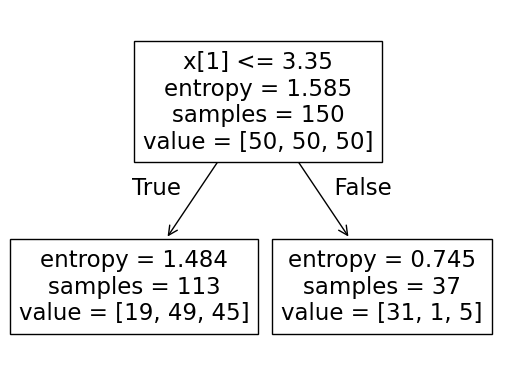

In [57]:
# Importando stumps da biblioteca sci-kit-learn conforme acordado em sala:
from sklearn import tree

def get_stump():
    return tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=1, max_features=1, max_leaf_nodes = 2)

# Aplicando em um dataset que já conheço:
from sklearn.datasets import load_iris
clf = get_stump()
iris = load_iris()
clf = clf.fit(iris.data, iris.target)
tree.plot_tree(clf)

# Observe abaixo que, de fato, é uma árvore que usa uma só dimensão da entrada e toma uma só decisão

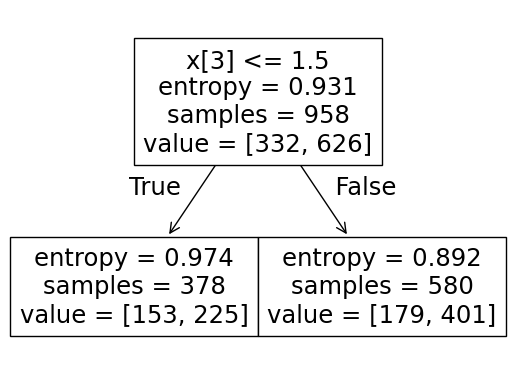

In [58]:
# Agora, aplicando no nosso dataset como exemplo:
# Primeiro, substituimos carateres por números
Xnum = X.copy().replace('x','1').replace('o','2').replace('b','3').astype(int) # assumindo b = blank, x = jogador 1, o = jogador 2
ynum = y.copy().replace('positive','1').replace('negative','-1').astype(int)

example_stump = get_stump()
example_stump.fit(Xnum,ynum)
tree.plot_tree(example_stump);

## Implementando boosting

De acordo com as aulas, o processo de Boosting (particulamente Adaboost), segue o seguinte fluxo:

1. A partir do dataset C completo, extraia o conjunto D1 com N dados únicos, e atribua peso 1/N para cada um;
2. Ajuste um stump H1, e calcule sua taxa de erro E1 em D1, dada pela soma dos pesos das decisões erradas;
3. Calcule o peso $\alpha = 0.5\cdot\log( (1-E1)/E1 )$, que será a importância da decisão de H1 para o decisor final;
4. Construa um conjunto D2 atualizando os pesos dos dados em D1, como <br> 
$w^{t+1}_i = \frac{w^t_i}{z}\cdot e^{-\alpha^t\cdot H^t \cdot y(X)}$, para $i = 1,2,\dots,N$; <br> 
com z sendo escalar que normaliza os pesos para que tenham soma unitária;
5. Repita até que o erro empirico do decisor $H^* = \alpha^1H^1+\alpha^2H^2+\dots+\alpha^2H^2$ seja menor que uma tolerância desejada, ou até que seja atingido um limite de iterações t predefinido.

In [49]:
# Rascunho: assuma d, e como decisoes e alphas 
import numpy as np
d = {}
e = {}
for i in range(1,6):
    d[i] = i*2

    if i%2==0:
        e[i] = 1
    else:
        e[i] = 0

np.sum(np.array([i for i in d.values()])*np.array([i for i in e.values()])) # Essa é a decisão H*
# Funciona! 

12

In [8]:
# Rascunho: a partir dos slides, o treino deeve see parecer com algo assim:
# xd1 = unique(X)
# yd1 = y[X.index]

# t = 1
# weights = {}
# stumps = {}
# weights[1] = np.ones(y.shape)/len(y)

# while (emp_error>=epsilon) or (t<=t_max)
#   stumps[t] = get_stump()
#   stumps[t].fit(xd1, yd1)
#   h = stumps[t].predict()

In [50]:
import pandas as pd
import numpy as np
yd = ynum.copy().values.reshape(-1,1).transpose()
ht = example_stump.predict(Xnum) #(N,)

w = np.ones((len(ynum),))/len(ynum) # 1xN
mistakes = np.where(ht==yd,0,1) # np.where(h-ynum.transpose()>0,1,0) # 1xN

e = np.sum(np.multiply(mistakes,w),axis = 1) # 1x1
a = 0.5*np.log((1-e)/e) 

w2 = w*np.exp(-a*np.multiply(ht,yd))
w2 = w2/np.sum(w2,axis = 1)

# sanity check:
display(pd.DataFrame(mistakes))
display(pd.DataFrame(w2))
display(pd.DataFrame(np.multiply(mistakes,w)))

,0,1,2,3,4,5,6,7,8,9,...,948,949,950,951,952,953,954,955,956,957
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


,0,1,2,3,4,5,6,7,8,9,...,948,949,950,951,952,953,954,955,956,957
0,0.000799,0.000799,0.000799,0.000799,0.000799,0.000799,0.000799,0.000799,0.000799,0.000799,...,0.001506,0.001506,0.001506,0.001506,0.001506,0.001506,0.001506,0.001506,0.001506,0.001506


,0,1,2,3,4,5,6,7,8,9,...,948,949,950,951,952,953,954,955,956,957
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001044,0.001044,0.001044,0.001044,0.001044,0.001044,0.001044,0.001044,0.001044,0.001044


## Validando em loop

emp_e:{1: 0.3465553235908142, 2: 0.3465553235908142, 3: 0.3465553235908142, 4: 0.3465553235908142, 5: 0.3465553235908142, 6: 0.3465553235908142, 7: 0.33298538622129437, 8: 0.3465553235908142, 9: 0.33089770354906056, 10: 0.33507306889352817, 11: 0.2849686847599165, 12: 0.24843423799582465, 13: 0.24947807933194155, 14: 0.24843423799582465, 15: 0.25156576200417535, 16: 0.24008350730688935, 17: 0.24947807933194155, 18: 0.2546972860125261, 19: 0.24739039665970772, 20: 0.2546972860125261, 21: 0.267223382045929, 22: 0.24947807933194155, 23: 0.24739039665970772, 24: 0.23695198329853862, 25: 0.23799582463465555, 26: 0.2536534446764092, 27: 0.24112734864300625, 28: 0.23799582463465555, 29: 0.24321503131524008, 30: 0.24008350730688935}
error:{1: array([0.34655532]), 2: array([0.44961796]), 3: array([0.45797214]), 4: array([0.46276217]), 5: array([0.47786923]), 6: array([0.45146337]), 7: array([0.4539015]), 8: array([0.45213163]), 9: array([0.46728067]), 10: array([0.47479669]), 11: array([0.33331

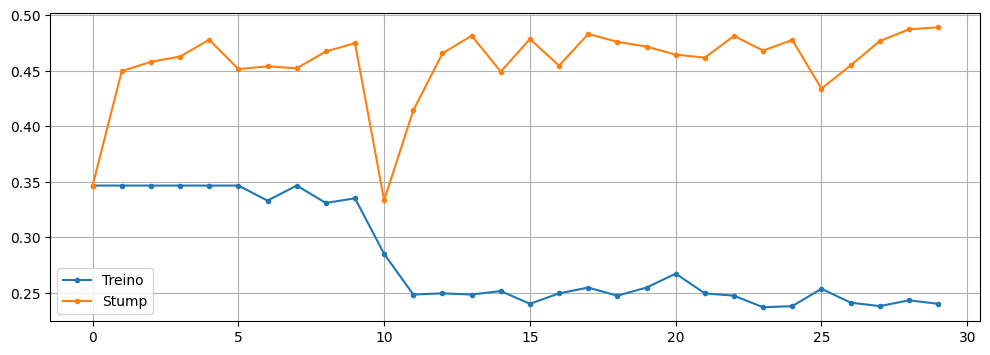

In [59]:
from matplotlib import pyplot as plt

yd = ynum.copy().values.reshape(-1,1).transpose()
xd = Xnum.copy()

t_max = 30
epsilon = 1/100
emp_error = np.inf

weights = {}
stumps = {}
error = {}
emp_e = {}
alpha = {}
t = 1

weights[t] = np.ones((1,yd.shape[1]))/yd.shape[1] 

while (emp_error>=epsilon) and (t<=t_max):
   stumps[t] = get_stump()
   stumps[t].fit(xd, yd.transpose(), sample_weight = weights[t].flatten())
   ht = stumps[t].predict(xd)

   mistakes = np.where(ht==yd,0,1)
   weighted_mistakes = np.multiply(mistakes,weights[t].flatten())
   
   error[t] = np.sum(weighted_mistakes,axis = 1)
   alpha[t] = 0.5*np.log((1-error[t])/error[t]) 

   weights[t+1] = weights[t]*np.exp(-alpha[t]*np.multiply(ht,yd))
   weights[t+1] = weights[t+1]/np.sum(weights[t+1])

   hstar = np.zeros(yd.shape)
   for tp in stumps.keys():
      pred = stumps[tp].predict(xd)
      hstar+= pred*alpha[tp]

   hstar = np.where(hstar>=0, 1,-1)
   emp_mistakes= np.where(hstar==yd,0,1)
   emp_error = np.sum(emp_mistakes)/yd.shape[1]
   emp_e[t] = emp_error
   t+=1

print(f'emp_e:{emp_e}')   
print(f'error:{error}')
print(f'alpha:{alpha}')
# print(f'weights:{weights}')

plt.figure(figsize=(12,4))
plt.plot([v for v in emp_e.values()], marker = '.', label = 'Treino')
plt.plot([v for v in error.values()], marker = '.', label = 'Stump')
plt.grid(True)
plt.legend()
plt.show()

## Documentando solução e validação separada do treino

emp_e:{1: 0.358814352574103, 2: 0.358814352574103, 3: 0.358814352574103, 4: 0.40249609984399376, 5: 0.3712948517940718, 6: 0.34321372854914195, 7: 0.34789391575663026, 8: 0.34789391575663026, 9: 0.34477379095163807, 10: 0.2948517940717629, 11: 0.28081123244929795, 12: 0.29797191887675506, 13: 0.2698907956318253, 14: 0.27769110764430577, 15: 0.26833073322932915, 16: 0.25585023400936036, 17: 0.2620904836193448, 18: 0.26521060842433697, 19: 0.26053042121684866, 20: 0.2542901716068643, 21: 0.26833073322932915, 22: 0.26053042121684866, 23: 0.27613104524180965, 24: 0.26053042121684866, 25: 0.2620904836193448, 26: 0.26053042121684866, 27: 0.26053042121684866, 28: 0.26365054602184085, 29: 0.26365054602184085, 30: 0.25273010920436817}
error:{1: array([0.35881435]), 2: array([0.45555379]), 3: array([0.45777509]), 4: array([0.43542286]), 5: array([0.47943449]), 6: array([0.43597425]), 7: array([0.44789126]), 8: array([0.48461833]), 9: array([0.48934702]), 10: array([0.33135502]), 11: array([0.470

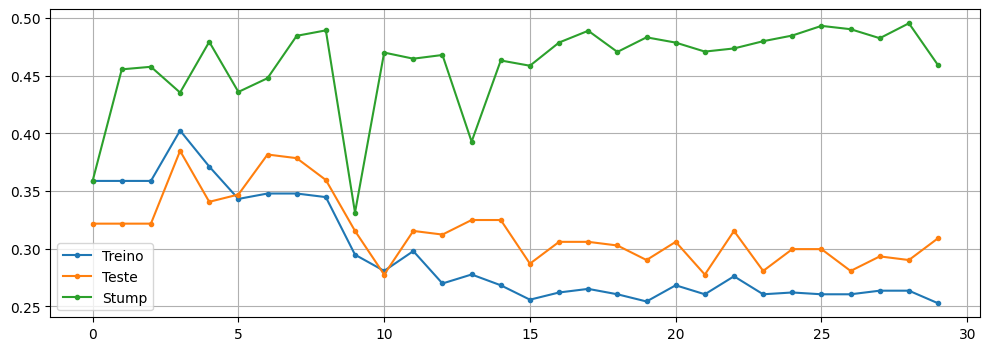

In [62]:
from sklearn.model_selection import train_test_split

yd = ynum.copy().values.reshape(-1,1)
xd = Xnum.copy()

X_train, X_test, y_train, y_test = train_test_split(xd, yd, test_size=0.33, random_state=42)
y_train = y_train.transpose()
y_test = y_test.transpose()

t_max = 30
epsilon = 1/100
emp_error = np.inf

weights = {}
stumps = {}
error = {}
emp_e = {}
val_e = {}
alpha = {}
t = 1

weights[t] = np.ones((1,y_train.shape[1]))/y_train.shape[1] 

while (emp_error>=epsilon) and (t<=t_max):

   # Criamos uma arvore de decisão que utiliza apenas 1 feature, 
   #  atravpes de uma só separação (2 nós-folha), com profundidade 1.
   #  As funções de custo a otimizar são a Entropia Binária e Ganho de Informação,
   #  utilizadas para seleção da feeature e da localização do separador
   stumps[t] = get_stump()

   # Aqui, aplicamos o treinamento com os dados apropriados e seus pesos 
   # (inicialmente uniformes, mas se ajustam a depender dos erros de cada stump anterior)
   stumps[t].fit(X_train, y_train.transpose(), sample_weight = weights[t].flatten())
   
   # A partir do novo stump, calculamos predições, medimos e ponderamos os erros
   ht = stumps[t].predict(X_train)   
   mistakes = np.where(ht==y_train,0,1)
   weighted_mistakes = np.multiply(mistakes,weights[t].flatten())
   
   # O erro e alpha do stump(iteração t) é calculado e registrado
   error[t] = np.sum(weighted_mistakes,axis = 1)
   alpha[t] = 0.5*np.log((1-error[t])/error[t]) 

   # Atualizamos os pesos e normalizamos para o treino do próximo stump
   weights[t+1] = weights[t]*np.exp(-alpha[t]*np.multiply(ht,y_train))
   weights[t+1] = weights[t+1]/np.sum(weights[t+1])

   # Calculamos e registramos o erro empírico 
   # (observe que aqui o dataset teste = treino, mas agora agregamos as decisões ponderadas)
   hstar = np.zeros(y_train.shape)
   for tp in stumps.keys():
      pred = alpha[tp]*stumps[tp].predict(X_train)
      hstar+= pred
   
   hstar = np.sign(hstar)
   emp_mistakes= np.where(hstar==y_train,0,1)
   emp_error = np.sum(emp_mistakes)/y_train.shape[1]
   emp_e[t] = emp_error

   # Calculamos e registramos o erro de validação (dados nunca vistos)
   hstar = np.zeros(y_test.shape)
   for tp in stumps.keys():
      pred = stumps[tp].predict(X_test)
      hstar+= pred*alpha[tp]

   hstar = np.sign(hstar)
   val_mistakes= np.where(hstar==y_test,0,1)
   val_error = np.sum(val_mistakes)/y_test.shape[1]
   val_e[t] = val_error

   # Atualizamos a iteração para o próximo stump
   t+=1

print(f'emp_e:{emp_e}')   
print(f'error:{error}')
print(f'alpha:{alpha}')

plt.figure(figsize=(12,4))
plt.plot([v for v in emp_e.values()], marker = '.', label = 'Treino')
plt.plot([v for v in val_e.values()], marker = '.', label = 'Teste')
plt.plot([v for v in error.values()], marker = '.', label = 'Stump')
plt.grid(True)
plt.legend()
plt.show()

## Abstraindo e gerando resultado final

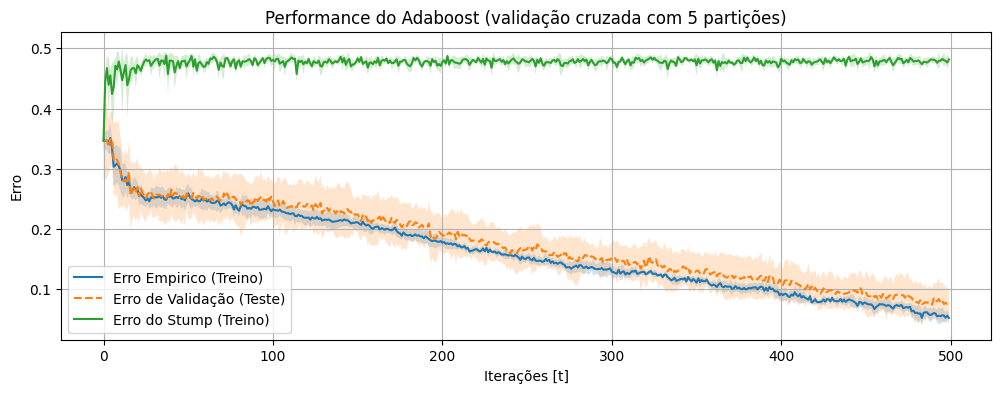

In [65]:
from sklearn.model_selection import KFold

# Função que gera os stumps 
def get_stump():
    return tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                       max_depth=1, max_features=1, max_leaf_nodes = 2)

# Função abstraindo o treinamento Adaboost implementado acima
def adaboost_train(X_train, y_train, X_test, y_test, t_max=30, epsilon=1/100):

    # Inicializa
    y_train = y_train.transpose()
    y_test = y_test.transpose()
    emp_error = np.inf

    weights = {}
    stumps = {}
    error = {}
    emp_e = {}
    val_e = {}
    alpha = {}
    
    # Primeira iteracao tem pesos iguais
    t = 1
    weights[t] = np.ones((1,y_train.shape[1]))/y_train.shape[1] 

    while (emp_error>=epsilon) and (t<=t_max):

        # Gera stump ("weak classifier") e treina com pesos adequados
        stumps[t] = get_stump()
        stumps[t].fit(X_train, y_train.transpose(), sample_weight = weights[t].flatten())
        ht = stumps[t].predict(X_train)

        # Calcula e pondera erros pelos seus pesos
        mistakes = np.where(ht==y_train,0,1)
        weighted_mistakes = np.multiply(mistakes,weights[t])
        
        # Calcula coeficiente de erro e alpha
        error[t] = np.sum(weighted_mistakes,axis = 1)
        alpha[t] = 0.5*np.log((1-error[t])/error[t]) 

        # Calcula pesos para treino do proximo stump
        weights[t+1] = weights[t]*np.exp(-alpha[t]*np.multiply(ht,y_train))
        weights[t+1] = weights[t+1]/np.sum(weights[t+1])

        # Registra performance do Ensemble atual em teste=treino
        hstar = np.zeros(y_train.shape)
        for tp in stumps.keys():
            pred = stumps[tp].predict(X_train)
            hstar+= pred*alpha[tp]

        hstar = np.where(hstar>=0, 1,-1)
        emp_mistakes= np.where(hstar==y_train,0,1)
        emp_error = np.sum(emp_mistakes)/y_train.shape[1]
        emp_e[t] = emp_error

        # Registra performance do Ensemble atual em validação
        hstar = np.zeros(y_test.shape)
        for tp in stumps.keys():
            pred = stumps[tp].predict(X_test)
            hstar+= pred*alpha[tp]

        hstar = np.where(hstar>=0, 1,-1)
        val_mistakes= np.where(hstar==y_test,0,1)
        val_error = np.sum(val_mistakes)/y_test.shape[1]
        val_e[t] = val_error

        t+=1 # proxima iteracao

    return stumps, alpha, weights, emp_e, val_e, error

# Função que implementa a validação cruzada 
def k_fold_cross_validation(X, y, k=5, t_max=30, epsilon=1/100, random_state=42):

    # Funcao simples do scikit-learn que gera conjundos de partições 
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    # Inicialização
    fold_emp_errors = []
    fold_val_errors = []
    fold_stump_errors = []
    fold_weights = []
    fold_alphas = []

    # Para cada partição gerada
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Treina o modelo para cada partição
        stumps, alpha, weights, emp_e,val_e,error = adaboost_train(
            X_train, y_train, X_val, y_val, t_max=t_max, epsilon=epsilon)

        # Registra erros do stump (treino) e ensemble (treino e validação)
        fold_emp_errors.append(list(emp_e.values()))
        fold_val_errors.append(list(val_e.values()))
        fold_stump_errors.append(list(error.values()))
        fold_alphas.append(list(alpha.values()))
        fold_weights.append(list(weights.values()))

    return fold_alphas, fold_weights, fold_emp_errors, fold_val_errors, fold_stump_errors

# Testando:
yd = ynum.copy().values.reshape(-1, 1)
xd = Xnum.copy().values

k = 5  # Numero de partições
t_max = 500 # Maximo de iterações
epsilon = 1 / 100 # Tolerancia de erro para parada

# Calcula medidas
fold_alphas, fold_weights, fold_emp_errors, fold_val_errors, fold_stump_errors = k_fold_cross_validation(
    xd, yd, k=k, t_max=t_max, epsilon=epsilon)

# Mostrando resultado
mean_emp_errors = np.mean(fold_emp_errors, axis=0)
std_emp_errors = np.std(fold_emp_errors, axis=0)

mean_val_errors = np.mean(fold_val_errors, axis=0)
std_val_errors = np.std(fold_val_errors, axis=0)

mean_stump_errors = np.mean(fold_stump_errors, axis=0).reshape(-1)
std_stump_errors = np.std(fold_stump_errors, axis=0).reshape(-1)

plt.figure(figsize=(12, 4))
plt.plot(mean_emp_errors, 
        #  marker='.', 
         label='Erro Empirico (Treino)')
plt.fill_between(range(len(mean_emp_errors)), mean_emp_errors - std_emp_errors, mean_emp_errors + std_emp_errors, alpha=0.2)

plt.plot(mean_val_errors,
        #  marker='.',
           label='Erro de Validação (Teste)', linestyle='dashed')
plt.fill_between(range(len(mean_val_errors)), mean_val_errors - std_val_errors, mean_val_errors + std_val_errors, alpha=0.2)

plt.plot(mean_stump_errors, 
        #  marker='.', 
         label='Erro do Stump (Treino)')
plt.fill_between(range(len(mean_stump_errors)), mean_stump_errors - std_stump_errors, mean_stump_errors + std_stump_errors, alpha=0.2)

plt.grid(True)
plt.legend()
plt.xlabel('Iterações [t]')
plt.ylabel('Erro')
plt.title('Performance do Adaboost (validação cruzada com 5 partições)')
plt.show()

# Observe abaixo que, conforme esperado, o erro de cada stump tende a 50% ao passo quee o erro do ensemble tende a 0

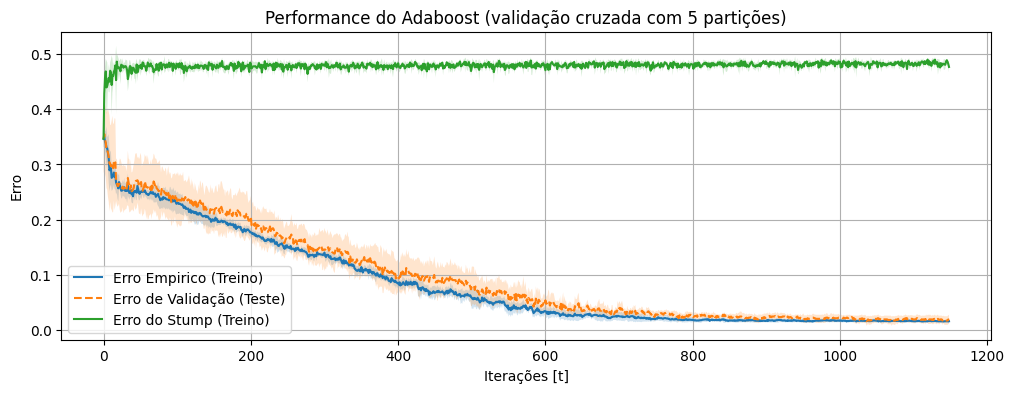

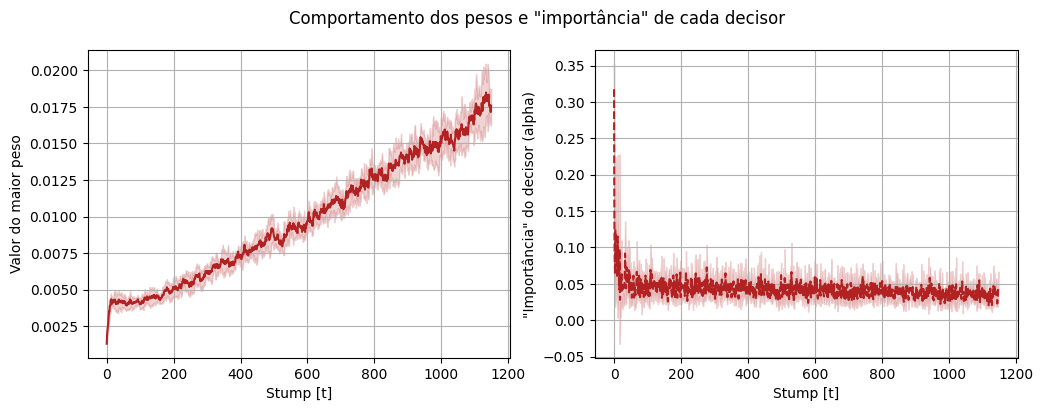

In [175]:
# Outro exemplo, com mais iterações que exemplos
yd = ynum.copy().values.reshape(-1, 1)
xd = Xnum.copy().values

k = 5  # Numero de partições
t_max = 1.2*len(yd) # Maximo de iterações
epsilon = 1 / 100 # Tolerancia de erro para parada

# Calcula medidas
fold_alphas, fold_weights, fold_emp_errors, fold_val_errors, fold_stump_errors = k_fold_cross_validation(
    xd, yd, k=k, t_max=t_max, epsilon=epsilon)

# Mostrando resultado
mean_emp_errors = np.mean(fold_emp_errors, axis=0)
std_emp_errors = np.std(fold_emp_errors, axis=0)

mean_val_errors = np.mean(fold_val_errors, axis=0)
std_val_errors = np.std(fold_val_errors, axis=0)

mean_stump_errors = np.mean(fold_stump_errors, axis=0).reshape(-1)
std_stump_errors = np.std(fold_stump_errors, axis=0).reshape(-1)

plt.figure(figsize=(12, 4))
plt.plot(mean_emp_errors, label='Erro Empirico (Treino)')
plt.fill_between(range(len(mean_emp_errors)), mean_emp_errors - std_emp_errors, mean_emp_errors + std_emp_errors, alpha=0.2)

plt.plot(mean_val_errors, label='Erro de Validação (Teste)', linestyle='dashed')
plt.fill_between(range(len(mean_val_errors)), mean_val_errors - std_val_errors, mean_val_errors + std_val_errors, alpha=0.2)

plt.plot(mean_stump_errors, label='Erro do Stump (Treino)')
plt.fill_between(range(len(mean_stump_errors)), mean_stump_errors - std_stump_errors, mean_stump_errors + std_stump_errors, alpha=0.2)

plt.grid(True)
plt.legend()
plt.xlabel('Iterações [t]')
plt.ylabel('Erro')
plt.title('Performance do Adaboost (validação cruzada com 5 partições)')
plt.show()

mean_weights_errors =np.mean(np.array([np.max(w, axis=2) for w in fold_weights]), axis =0).reshape(-1) 
std_weights_errors = np.std(np.array([np.max(w, axis=2) for w in fold_weights]), axis =0).reshape(-1) 

mean_alphas_errors = np.mean(fold_alphas, axis=0).reshape(-1)
std_alphas_errors = np.std(fold_alphas, axis=0).reshape(-1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(mean_weights_errors,  label='Média do maior peso',color = 'firebrick')
plt.fill_between(range(len(mean_weights_errors)), mean_weights_errors - std_weights_errors, mean_weights_errors + std_weights_errors, 
                 alpha=0.2,color = 'firebrick')
plt.ylabel('Valor do maior peso')
plt.xlabel('Stump [t]')
plt.grid(True)

plt.subplot(122)
plt.plot(mean_alphas_errors, label='"Importância" do decisor (alpha)', linestyle='dashed', color = 'firebrick')
plt.fill_between(range(len(mean_alphas_errors)), mean_alphas_errors - std_alphas_errors, mean_alphas_errors + std_alphas_errors,
                  alpha=0.2,color = 'firebrick')
plt.ylabel('"Importância" do decisor (alpha)')
plt.xlabel('Stump [t]')
plt.grid(True)

plt.suptitle('Comportamento dos pesos e "importância" de cada decisor')
plt.show()


# 30mins para executar, aprox.

## Comentários finais:

O algoritmo apresentou o comportamento esperado a partir das discussões em sala de aula, de forma que o erro de cada stump aumenta (tendendo a 0.5) ao passo que o erro empírico e de validação reduzem, com erro empírico menor ou igual ao de validação.

Conforme esperado - em validação cruzada - é possível observar alguma variabilidade nos resultados entre um ensemble e outro, principalmente no erro de validação. Porém, a tendência do comportamento é a mesma: o erro do stump se aproxima de 50% à medida que o erro empírico é minimizado (e por consequência, também o de validação) de tal forma que a decisão de stumps de iterações finais tem cada vez menor importância mas a decisão coletiva melhora (erro de validação diminui).

Além disso, mesmo executando um número elevado de iterações (maior que o número de exemplos no banco de dados), o erro de validação não desviou do erro empírico, ilustrando a resistência por design do algoritmo Adaboost a overfitting. Vemos também que os pesos aumentam gradativamente, priorizando aprendizado de instâncias mais difíceis (onde o modelo ainda erra), e que a importância (alpha) de cada decisor cai de maneira correspondente, conforme esperado.

Em resumo, é demonstrada a capacidade do algoritmo Adaboost de produzir um conjunto de "classificadores fracos" que agregados por ponderação são capazes de otimizar a eficácia do modelo sem causar overfitting (em teoria).